In [30]:
%load_ext autoreload
%autoreload 2

In [31]:
import model.model
import model.helpers as helpers
import model.agents as agents
import visualisation
import visualisation.l1
import visualisation.meta
import visualisation.dimscrap

from model.model import ReductionModel
from model.helpers import load_vectors, generate_word_vectors, generate_zipfian_sample, load_info, compute_average_vocabulary, compute_mean_communicative_success_per_token

In [32]:
from model.types.neighbourhood import NeighbourhoodTypes
from model.types.production import ProductionModels
from model.types.reduction import ReductionModes
from model.types.feedback import FeedbackTypes
from model.types.repair import Repair

In [87]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [174]:
NUM_AGENTS = 25
NUM_DIMENSIONS = 200
NUM_TOKENS = 100
# vectors, tokens, frequencies, percentiles = load_vectors(f"materials/vectors-{NUM_DIMENSIONS}.txt")
tokens, frequencies, percentiles, ranks = load_info(f"vectors/theoretical-percentile-info-{NUM_TOKENS}.tsv", theoretical=True)
# Overwrite vectors with my own
vectors = generate_word_vectors(vocabulary_size=len(tokens), dimensions=NUM_DIMENSIONS)

In [230]:
STEPS_COUNT = 2000
model = ReductionModel(NUM_AGENTS, vectors, tokens, frequencies, percentiles, ranks,
                       initial_token_count=6,
                       neighbourhood_size=10, 
                       neighbourhood_type=NeighbourhoodTypes.NEAREST,
                       reduction_prior=0.5,
                       production_model=ProductionModels.SINGLE_EXEMPLAR,
                       reduction_mode=ReductionModes.ALWAYS,
                       feedback_type=FeedbackTypes.NO_FEEDBACK,
                       repair=Repair.NO_REPAIR,
                       datacollector_step_size=50,
                       disable_reduction=False)
# model.agents[0].indices_in_memory
# model.step()
for _ in tqdm(range(STEPS_COUNT), total=STEPS_COUNT):
    model.step()

Lower dimension limit is 20


  0%|          | 0/2000 [00:00<?, ?it/s]

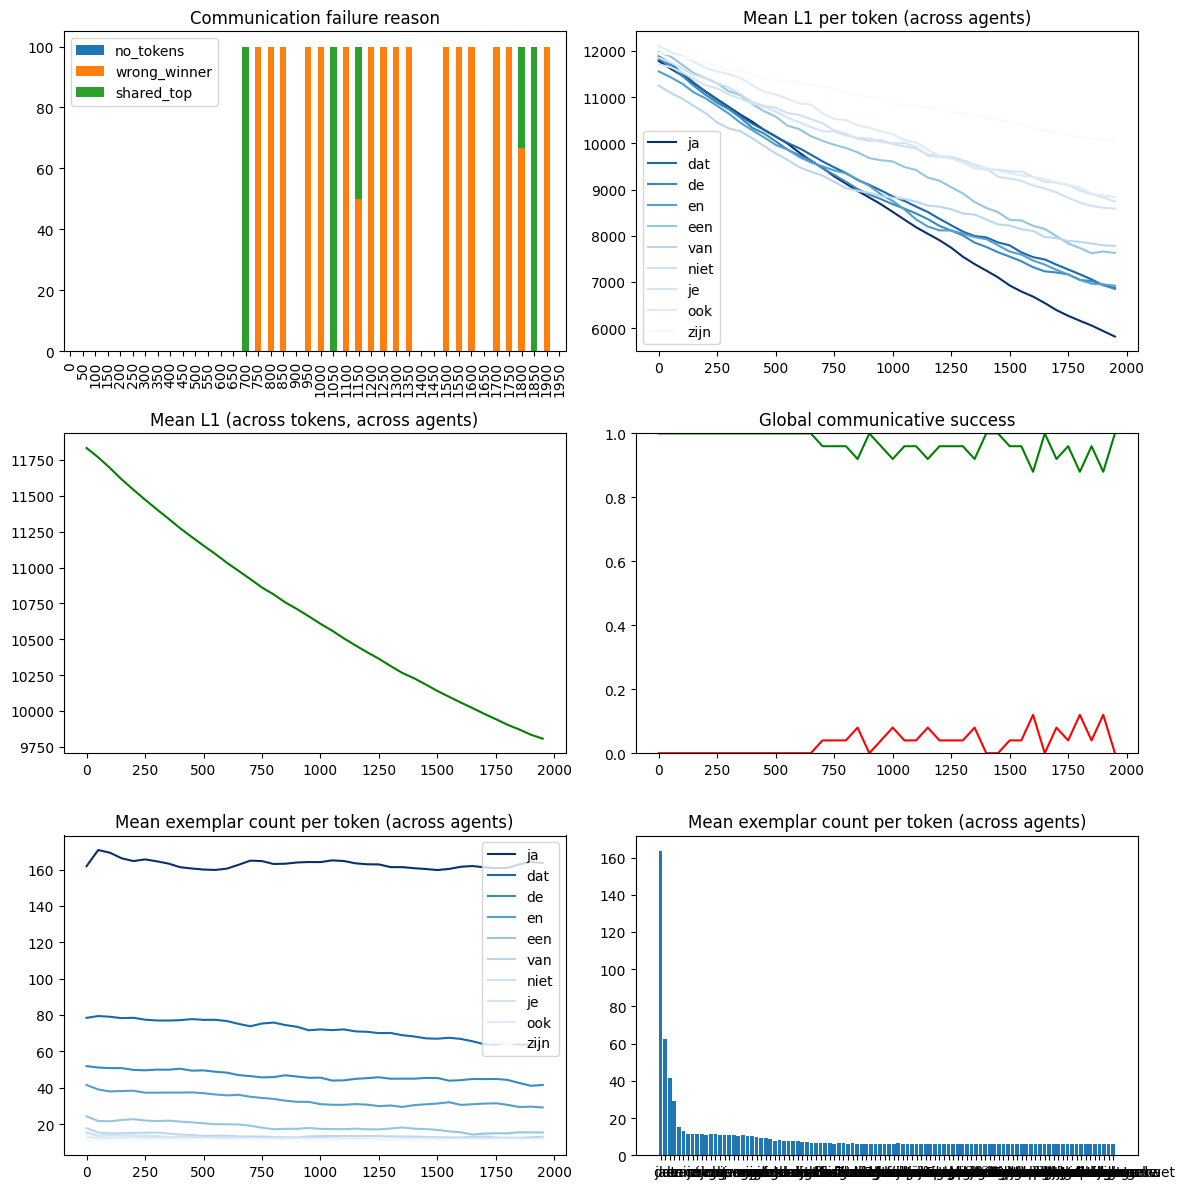

In [223]:
visualisation.meta.combine_plots(model,
            visualisation.l1.make_fail_reason_plot,
            visualisation.l1.words_l1_plot_first_n,
            lambda model, ax: visualisation.l1.make_mean_l1_plot(model, ax=ax, smooth=False),
            lambda model, ax: visualisation.dimscrap.make_communication_plot(model, ax=ax, smooth=False),
            visualisation.l1.words_mean_exemplar_count_first_n,
            visualisation.l1.words_mean_exemplar_count_bar)

/home/local/anthe/Projects/fwo-frequency-reduction/visualisation/meta.py:60: RuntimeWarning: invalid value encountered in divide
  row_sums = confusion_matrix.sum(axis=1, keepdims=True)
/home/local/anthe/Projects/fwo-frequency-reduction/visualisation/meta.py:60: RuntimeWarning: invalid value encountered in divide
  row_sums = confusion_matrix.sum(axis=1, keepdims=True)
/home/local/anthe/Projects/fwo-frequency-reduction/visualisation/meta.py:60: RuntimeWarning: invalid value encountered in divide
  row_sums = confusion_matrix.sum(axis=1, keepdims=True)
/home/local/anthe/Projects/fwo-frequency-reduction/visualisation/meta.py:60: RuntimeWarning: invalid value encountered in divide
  row_sums = confusion_matrix.sum(axis=1, keepdims=True)


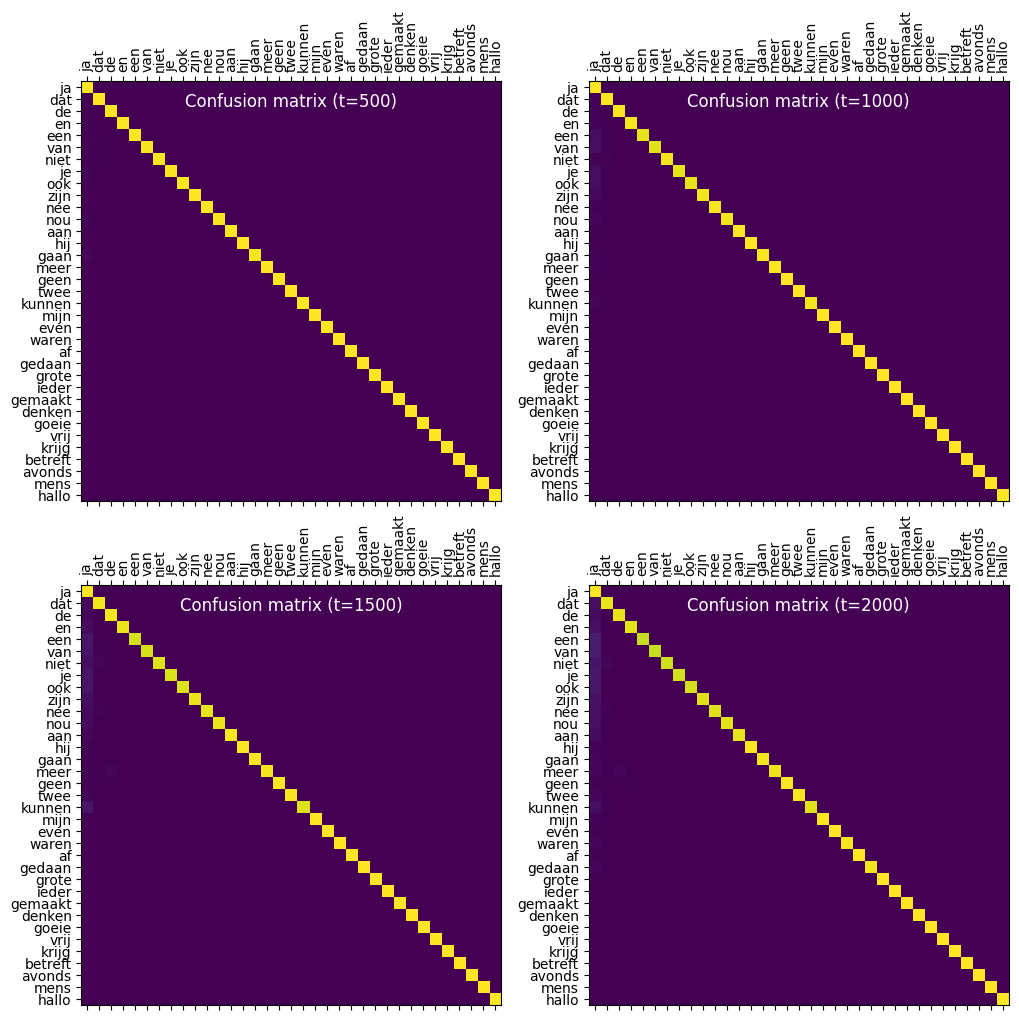

In [235]:
visualisation.meta.make_layout_plot(model,
                                    visualisation.meta.make_confusion_plot,
                                    n=35, steps=[math.floor(model.current_step / 4) * 1,
                                                 math.floor(model.current_step / 4) * 2,
                                                 math.floor(model.current_step / 4) * 3, model.current_step])

IndexError: single positional indexer is out-of-bounds

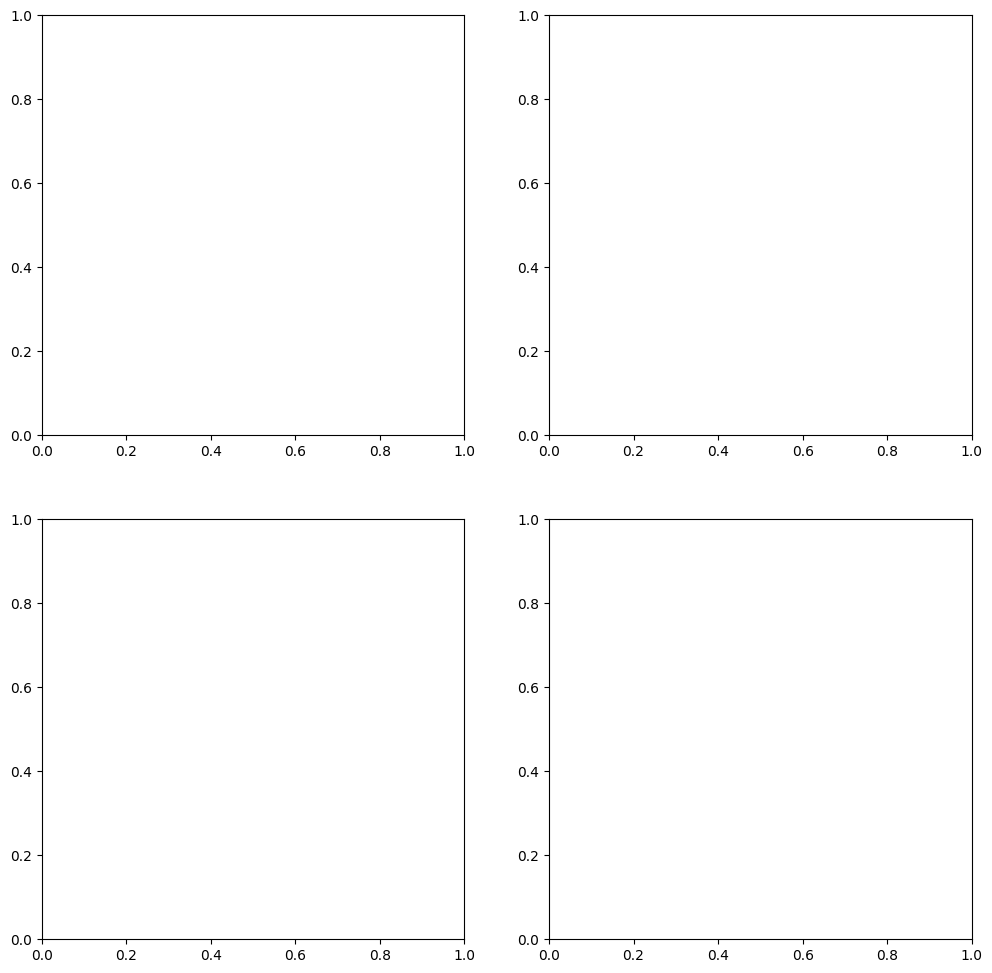

In [208]:
visualisation.meta.make_layout_plot(model,
                                    visualisation.meta.make_umap_plot,
                                    steps=[math.floor(model.current_step / 4) * 1,
                                           math.floor(model.current_step / 4) * 2,
                                           math.floor(model.current_step / 4) * 3, model.current_step - 1])

KeyError: 'words_zero_ratio'

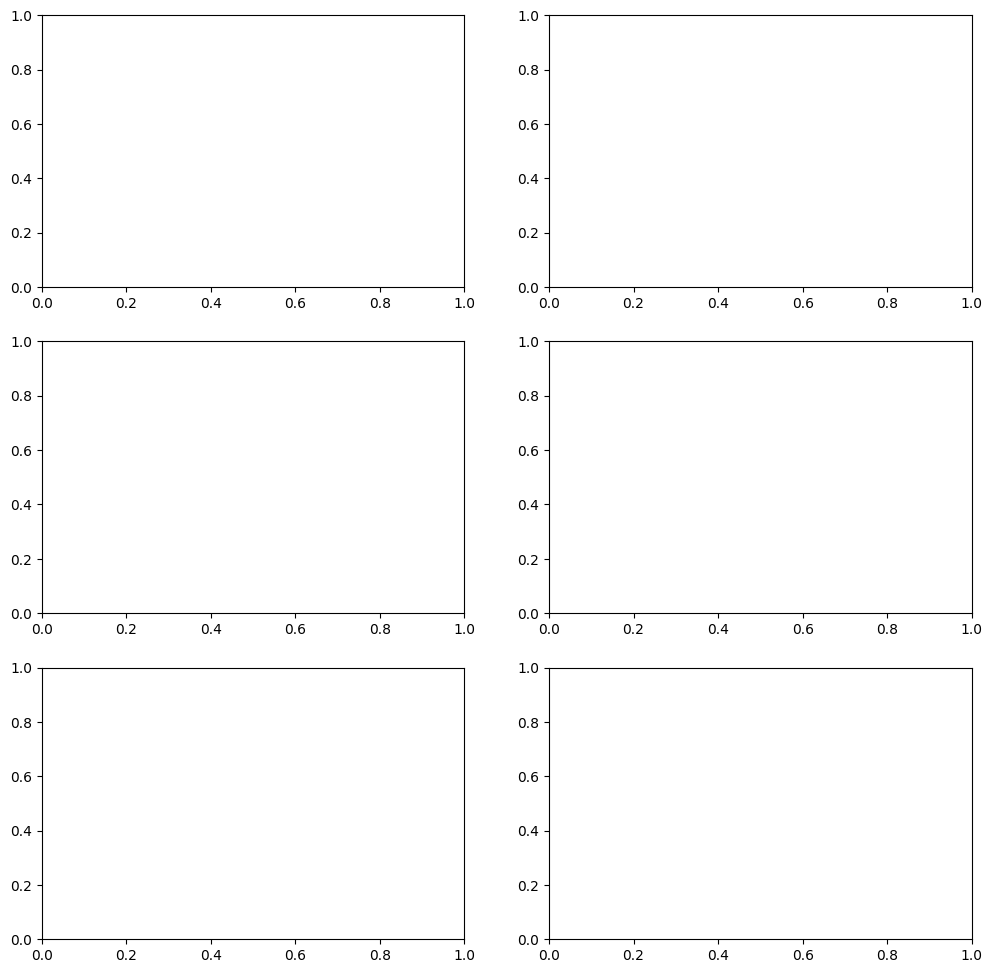

In [21]:
combine_plots(model, words_reduction_plot,
              make_communication_plot,
              lambda model, ax: words_communication_success_first_n(model, ax=ax, attr="mean_reduction_per_token"),
              words_communication_success_first_n,
              words_reduction_plot_first_n,
              make_repairs_plot)

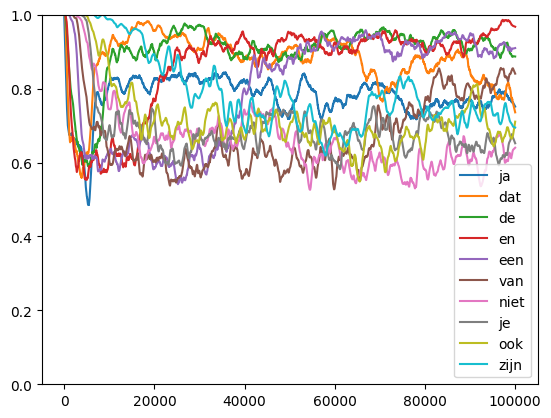

In [197]:
words_communication_success_first_n(model)

KeyError: 'average_vocabulary'

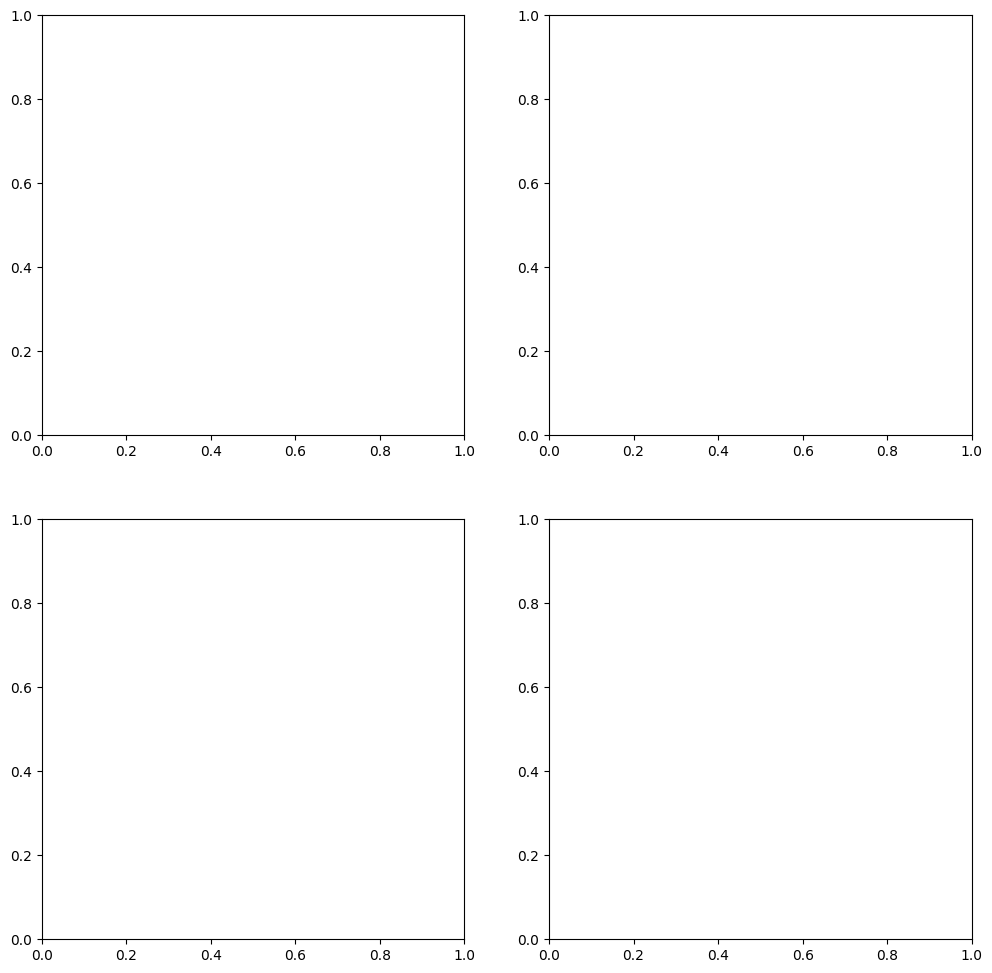

In [40]:
visualisation_meta.make_layout_plot(model, visualisation_meta.make_umap_plot,steps=[1, 1000, 5000, model.steps])

In [1]:
import numpy as np

# Example vocabulary matrix with shape (token_count, dimension_count)
vocabulary_matrix = np.array([[1, 2, 3, 4, 5], [2, 8, 9, 6, 5], [9, 6, 3, 8, 7]])
print(vocabulary_matrix.shape)

# Number of copies you want for each token
num_copies = 5

# Add a new axis and repeat each token (row) 20 times
expanded_vocabulary_matrix = np.tile(vocabulary_matrix[:, np.newaxis, :], (1, num_copies, 1))

token_index = 0
exemplar_index = 5
#expanded_vocabulary_matrix[token_index, exemplar_index, :]

expanded_vocabulary_matrix[token_index, :-1, :] = expanded_vocabulary_matrix[token_index, 1:, :]
expanded_vocabulary_matrix[token_index, -1, :] = [5, 0, 5, 0, 5]
single_agent_r = (expanded_vocabulary_matrix == 0).sum(axis=2).sum(axis=1) / (num_copies * 5)
# Faux copy it a few more times
#np.tile(single_agent_r, (5, 1)).mean(axis=0)

np.zeros(single_agent_r)

(3, 5)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [119]:
proportion_successful = 1
reduction_count = 1
epsilon = 0.001
u = math.sqrt((proportion_successful * (1 - proportion_successful)) + epsilon / ((reduction_count) + epsilon))
print(u)
k = 4
theta = 0.5
lamb = 3
p_reduce = (1 / (1 + np.exp(-k * (proportion_successful - theta - lamb * u))))
p_reduce

0.0316069770620507


0.8348938892334717